# üöÄ Snorkel Intro Tutorial: Spam Detection

In this tutorial, we will walk through the process of using Snorkel to build a training set for classifying YouTube comments as `SPAM` or `HAM` (not spam).
The goal of this tutorial is to illustrate the basic components and concepts of Snorkel in a simple way, but also to dive into the actual process of iteratively developing real applications in Snorkel.
For an overview of Snorkel, visit [snorkel.org](http://snorkel.org).
You can also check out the [Snorkel API documentation](https://snorkel.readthedocs.io/).

For our task, we have access to a large amount of *unlabeled data* in the form of YouTube comments with some metadata.
Our goal is to train a classifier over the comment data that can predict whether a comment is spam or not.
To do that, we need to label our data, but doing so for real world applications can be prohibitively slow and expensive, often taking person-weeks or months of hand-labeling.

We therefore turn to weak supervision using **_labeling functions_**, or noisy, programmatic heuristics, to assign labels to unlabeled training data efficiently.
We also have access to a small amount of labeled data, which we only use for evaluation purposes.

The tutorial is divided into four parts:
1. **Loading Data**: We load a [YouTube comments dataset](https://www.kaggle.com/goneee/youtube-spam-classifiedcomments) from Kaggle.

2. **Writing Labeling Functions**: We write Python programs that take as input a data point and assign labels (or abstain) using heuristics, pattern matching, and third-party models.

3. **Combining Labeling Function Outputs with the Label Model**: We use the outputs of the labeling functions over the training set as input to the label model, which assigns probabilistic labels to the training set.

4. **Training a Classifier**: We train a classifier that can predict labels for *any* YouTube comment (not just the ones labeled by the labeling functions) using the probabilistic training labels from step 3.

### Task: Spam Detection

We use a [YouTube comments dataset](https://www.kaggle.com/goneee/youtube-spam-classifiedcomments) that consists of YouTube comments from 5 videos. The task is to classify each comment as being

* **`SPAM`**: irrelevant or inappropriate messages, or
* **`HAM`**: comments relevant to the video

For example, the following comments are `SPAM`:

        "Subscribe to me for free Android games, apps.."

        "Please check out my vidios"

        "Subscribe to me and I'll subscribe back!!!"

and these are `HAM`:

        "3:46 so cute!"

        "This looks so fun and it's a good song"

        "This is a weird video."

### Data Splits in Snorkel

We split our data into 4 sets:
* **Training Set**: The largest split of the dataset. We do not have ground truth or "gold" labels for these data points; we will be generating their labels with weak supervision.
* \[Optional\] **Development Set**: A small labeled subset of the training data (e.g. 100 points) to guide LF iteration. See note below.
* **Validation Set**: A labeled set used to tune hyperparameters and/or perform early stopping while training the classifier.
* **Test Set**: A labeled set for final evaluation of our classifier. This set should only be used for final evaluation, _not_ error analysis.


While it is possible to develop labeling functions on the unlabeled training set only, users often find it more time-efficient to label a small dev set to provide a quick approximate signal on the accuracies and failure modes of their LFs (rather than scrolling through training examples and mentally assessing approximate accuracy).
Alternatively, users sometimes will have the validation set also serve as the development set.
Do the latter only with caution: because the labeling functions will be based on examples from the validation set, the validation set will no longer be an unbiased proxy for the test set.

## 1. Loading Data

We load the Kaggle dataset and create Pandas DataFrame objects for each of the sets described above.
DataFrames are extremely popular in Python data analysis workloads, and Snorkel provides native support
for several DataFrame-like data structures, including Pandas, Dask, and PySpark.
For more information on working with Pandas DataFrames, see the [Pandas DataFrame guide](https://pandas.pydata.org/pandas-docs/stable/getting_started/dsintro.html).

Each DataFrame consists of the following fields:
* **`author`**: Username of the comment author
* **`data`**: Date and time the comment was posted
* **`text`**: Raw text content of the comment
* **`label`**: Whether the comment is `SPAM` (1), `HAM` (0), or `UNKNOWN/ABSTAIN` (-1)
* **`video`**: Video the comment is associated with

We start by loading our data.
The `load_spam_dataset()` method downloads the raw CSV files from the internet, divides them into splits, converts them into DataFrames, and shuffles them.
As mentioned above, the dataset contains comments from 5 of the most popular YouTube videos during a period between 2014 and 2015.
* The first four videos' comments are combined to form the `train` set. This set has no gold labels.
* The `dev` set is a random sample of 200 data points from the `train` set with gold labels added.
* The fifth video is split 50/50 between a validation set (`valid`) and `test` set.

In [1]:
%matplotlib inline

import os

# For reproducibility
os.environ["PYTHONHASHSEED"] = "0"

# Turn off TensorFlow logging messages
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Make sure we're running from the spam/ directory
if os.path.basename(os.getcwd()) == "snorkel-tutorials":
    os.chdir("spam")

In [2]:
from utils import load_spam_dataset

df_train, df_dev, df_valid, df_test = load_spam_dataset()

# We pull out the label vectors for ease of use later
Y_dev = df_dev["label"].values
Y_valid = df_valid["label"].values
Y_test = df_test["label"].values

Let's view a few examples.

In [3]:
import pandas as pd

# Don't truncate text fields in the display
pd.set_option("display.max_colwidth", 0)

df_dev.sample(5, random_state=3)

author                        date  \
128  Pepe The Meme King  2015-05-19T03:49:29.427000   
151  Melissa Erhart      NaN                          
31   Angel               2014-11-02T17:27:09          
29   Sandeep Singh       2015-05-23T17:51:58.957000   
237  BigBird Larry       2015-05-24T09:48:00.835000   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             text  \
128  everyday I&#39;m shufflinÔªø                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
151  Check out this playlist on YouTube:chcfcvzfzfbvzdrÔªø                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
31   Hi there~I'm group leader of Angel, a rookie Korean pop group. We have four  members, Chanicka, Julie, Stephanie, and myself, Leah. Please feel free to  check out our channel and leave some feedback on our cover videos (:  criticism is welcome as we know we're not top notch singers so please come  leave some constructive feedback on our videos; we appreciate any chance to  improve before auditioning for a Korean management company. We plan on  auditioning for JYP, BigHit, Jellyfish, YG or SM. Thank you for taking time  out of your day to read this !Ôªø   
29   Charlie from LOSTÔªø                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
237  Every single one of his songs brings me back to place I can never go back to and it hurts so bad insideÔªø                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

     label  video  
128  0      3      
151  1      4      
31   1      1      
29   0      4      
237  0      4

The class distribution varies slightly from class to class, but all are approximately class-balanced.
You can verify this by looking at the `dev` set labels.

In [4]:
# For clarity, we define constants to represent the class labels for spam, ham, and abstaining.
ABSTAIN = -1
HAM = 0
SPAM = 1

for split_name, df in [("dev", df_dev), ("valid", df_valid), ("test", df_test)]:
    spam_freq = (df["label"].values == SPAM).mean()
    print(f"{split_name.upper():<6} {spam_freq * 100:0.1f}% SPAM")

DEV    54.0% SPAM
VALID  46.7% SPAM
TEST   47.2% SPAM


## 2. Write Labeling Functions (LFs)

### A gentle introduction to LFs

**Labeling functions (LFs) help users encode domain knowledge and other supervision sources programmatically.**

LFs are heuristics that take as input a data point and either assign a label to it (in this case, `HAM` or `SPAM`) or abstain (don't assign any label). Labeling functions can be *noisy*: they don't have perfect accuracy and don't have to label every data point.
Moreover, different labeling functions can overlap (label the same data point) and even conflict (assign different labels to the same data point). This is expected, and we demonstrate how we deal with this later.

Because their only requirement is that they map a data point a label (or abstain), they can wrap a wide variety of forms of supervision. Examples include, but are not limited to:
* *Keyword searches*: looking for specific words in a sentence
* *Pattern matching*: looking for specific syntactical patterns
* *Third-party models*: using an pre-trained model (usually a model for a different task than the one at hand)
* *Distant supervision*: using external knowledge base
* *Crowdworker labels*: treating each crowdworker as a black-box function that assigns labels to subsets of the data

### Recommended practice for LF development

Typical LF development cycles include multiple iterations of ideation, refining, evaluation, and debugging.
A typical cycle consists of the following steps:

1. Look at examples to generate ideas for LFs
1. Write an initial version of an LF
1. Spot check its performance by looking at its output on examples in the training set (or development set if available)
1. Refine and debug to improve coverage or accuracy as necessary

Our goal for LF development is to create a high quality set of training labels for our unlabeled data set,
not to label everything or directly create a model for inference using the LFs.
The training labels are used to train a separate discriminative model (in this case, one which just uses the comment text) in order to generalize to new, unseen examples.
Using this model, we can make predictions for data points that our LFs don't cover.

We'll walk through the development of two LFs using basic analysis tools in Snorkel, then provide a full set of LFs that we developed for this tutorial.

### a) Exploring the development set for initial ideas

We'll start by looking at the `train` set to generate some ideas for LFs.

In [5]:
df_train[["author", "text", "video"]].sample(20, random_state=2)

author  \
4    ambareesh nimkar          
87   pratik patel              
14   RaMpAgE420                
80   Jason Haddad              
104  austin green              
305  M.E.S                     
22   John Monster              
338  Alanoud Alsaleh           
336  Leonardo Baptista         
143  UKz DoleSnacher           
163  Monica Parker             
129  b0b1t.48058475            
277  MeSoHornyMeLuvULongTime   
265  HarveyIsTheBoss           
214  janez novak               
76   Bizzle Sperq              
123  Gaming and Stuff PRO      
268  Young IncoVEVO            
433  Chris Edgar               
40   rap classics              

                                                                                                                                                                                                                                                                                                                              text  \
4    "eye of the tiger" "i am the champion" seems like katy perry is using  titles of old rock songs for lyrics..Ôªø                                                                                                                                                                                                                   
87   mindblowing dance.,.,.superbbb songÔªø                                                                                                                                                                                                                                                                                            
14   Check out Berzerk video on my channel ! :D                                                                                                                                                                                                                                                                                      
80   Hey, check out my new website!! This site is about kids stuff. kidsmediausa  . com                                                                                                                                                                                                                                              
104  Eminem is my insperasen and favÔªø                                                                                                                                                                                                                                                                                                
305  hey guys look im aware im spamming and it pisses people off but please take a moment to check out my music.  im a young rapper and i love to do it and i just wanna share my music with more people  just click my picture and then see if you like my stuff                                                                    
22   Œüh my god ... Roar is the most liked video at Vevo .. while 2 months ago  was Justin's Baby.. congrats Katy . Applause &lt;3 Ôªø                                                                                                                                                                                                  
338  I started hating Katy Perry after finding out that she stole all of the  ideas on her videos  from an old comic book. Yet, her music is catchy. Ôªø                                                                                                                                                                               
336  http://www.avaaz.org/po/petition/Youtube_Corporation_Fox_Broadcasting_Company_Anular_os_strikes_no_Canal_Nostalgia/?cXPZpgb Ôªø                                                                                                                                                                                                   
143  Remove This video its wankÔªø                                          

One dominant pattern in the comments that look like spam is the use of the phrase "check out" (e.g. "check out my channel").
Let's start with that.

### b) Writing an LF to identify spammy comments that use the phrase "check out"

Labeling functions in Snorkel are created with the `@labeling_function()` decorator, which wraps a function for evaluating on a single data point (in this case, a row of the DataFrame).

Let's start developing an LF to catch instances of commenters trying to get people to "check out" their channel, video, or website.
We'll start by just looking for the exact string `"check out"` in the text, and compare that to looking for just `"check"` in the text.
We'll write a Python function over a single data point (here, a [Pandas `Series` object](https://pandas.pydata.org/pandas-docs/stable/reference/series.html)) to express the two versions of our rule, then add the decorator.

In [6]:
from snorkel.labeling.lf import labeling_function


@labeling_function()
def check(x):
    return SPAM if "check" in x.text.lower() else ABSTAIN

In [7]:
@labeling_function()
def check_out(x):
    return SPAM if "check out" in x.text.lower() else ABSTAIN

To apply one or more LFs that we've written to a collection of data points, we use an `LFApplier`. Because our data points are represented with a Pandas DataFrame in this tutorial, we use the `PandasLFApplier`.

In [8]:
from snorkel.labeling.apply import PandasLFApplier

lfs = [check_out, check]

applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)
L_dev = applier.apply(df=df_dev)

  0%|          | 0/1586 [00:00<?, ?it/s]

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1586/1586 [00:00<00:00, 36155.43it/s]


  0%|          | 0/100 [00:00<?, ?it/s]

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [00:00<00:00, 25018.22it/s]

The output of the `apply(...)` method is a label matrix which we generally refer to as `L` (or `L_[split name]`).

In [9]:
L_train

array([[-1, -1],
       [-1, -1],
       [-1,  1],
       ...,
       [ 1,  1],
       [-1,  1],
       [ 1,  1]])

### c) Evaluate performance on training and development sets

We can easily calculate the coverage of these LFs (i.e., the percentage of the dataset that they label) as follows:

In [10]:
coverage_check, coverage_check_out = (L_train != ABSTAIN).mean(axis=0)
print(f"check coverage: {coverage_check * 100:.1f}%")
print(f"check_out coverage: {coverage_check_out * 100:.1f}%")

check coverage: 21.4%
check_out coverage: 25.8%


However, Snorkel provides utilities for common LF analyses.
We report the following summary statistics for multiple LFs at once:

* **Polarity**: The set of labels this LF outputs
* **Coverage**: The fraction of the dataset the LF labels
* **Overlaps**: The fraction of the dataset where this LF and at least one other LF label
* **Conflicts**: The fraction of the dataset where this LF and at least one other LF label and disagree
* **Correct**: The number of data points this LF labels correctly (if gold labels are provided)
* **Incorrect**: The number of data points this LF labels incorrectly (if gold labels are provided)
* **Empirical Accuracy**: The empirical accuracy of this LF (if gold labels are provided)

For *Correct*, *Incorrect*, and *Empirical Accuracy*, we don't want to penalize the LF for examples where it abstained.
We calculate these statistics only over those examples where the LF output a label.

In [11]:
from snorkel.labeling.analysis import LFAnalysis

LFAnalysis(L=L_train, lfs=lfs).lf_summary()

j Polarity  Coverage  Overlaps  Conflicts
check_out  0  [1]      0.214376  0.214376  0.0      
check      1  [1]      0.257881  0.214376  0.0

In [12]:
LFAnalysis(L=L_dev, lfs=lfs).lf_summary(Y=Y_dev)

j Polarity  Coverage  Overlaps  Conflicts  Correct  Incorrect  \
check_out  0  [1]      0.22      0.22      0.0        22       0           
check      1  [1]      0.30      0.22      0.0        29       1           

           Emp. Acc.  
check_out  1.000000   
check      0.966667

So even these very simple rules do quite well!
We might want to pick the `check` rule, since both have high precision and `check` has higher coverage.
But let's look at our data to be sure.

The helper method `error_buckets()` groups examples by their predicted label and true label. For example, `buckets[(SPAM, HAM)]` contains the indices of data points that the LF labeled `SPAM` that actually belong to class `HAM`. This may give ideas for where the LF could be made more specific.

In [13]:
from snorkel.analysis.error_analysis import error_buckets

buckets = error_buckets(Y_dev, L_dev[:, 1])
df_dev.iloc[buckets[(SPAM, HAM)]]

author                 date  \
260  Eanna Cusack  2014-01-20T22:20:59   

                                        text  label  video  
260  Im just to check how much views it hasÔªø  0      1

So `check` produced a false positive that might occur for any very popular video on YouTube.
Now let's take a look at some places that `check` labeled `SPAM` on the `train` set to see if it matches our intuition or if we can identify some false positives.

In [14]:
df_train.iloc[L_train[:, 1] == SPAM].sample(10, random_state=1)

author                        date  \
305  M.E.S            NaN                          
265  Kawiana Lewis    2015-02-27T02:20:40.987000   
89   Stricker Stric   NaN                          
147  TheGenieBoy      NaN                          
240  Made2Falter      2014-09-09T23:55:30          
273  Artady           2014-08-11T16:27:55          
94   Nick McGoldrick  2014-10-27T13:19:06          
139  MFkin PRXPHETZ   2014-01-20T09:08:39          
303  Ïù¥ Ï†ïÌõà             NaN                          
246  media.uploader   NaN                          

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           text  \
305  hey guys look im aware im spamming and it pisses people off but please take a moment to check out my music.  im a young rapper and i love to do it and i just wanna share my music with more people  just click my picture and then see if you like my stuff                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
265  Check out this video on YouTube:opponents mm <br /><br /><br /><br />--‚Ä¢[‚Ä¢‚Ä¢‚Ä¢‚Ä¢=====++¬•¬•¬£¬£¬£<br />Ôªø                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
89   eminem new song check out my videos                                                                                                                                                                                                                                                                                                         

No clear false positives here, but many look like they could be labeled by `check_out` as well.
Let's see where `check_out` abstained, but `check` labeled.

In [15]:
buckets = error_buckets(L_train[:, 0], L_train[:, 1])
df_train.iloc[buckets[(SPAM, ABSTAIN)]].sample(10, random_state=1)

author                        date  \
403  ownpear902          2014-07-22T18:44:36.299000   
256  PacKmaN             2014-11-05T21:56:39          
196  Angek95             2014-11-03T22:28:56          
282  CronicleFPS         2014-11-06T03:10:26          
352  MrJtill0317         NaN                          
161  MarianMusicChannel  2014-08-24T03:57:52          
270  Kyle Jaber          2014-01-19T00:21:29          
292  Soundhase           2014-08-19T18:59:38          
179  Nerdy Peach         2014-10-29T22:44:41          
16   zhichao wang        2013-11-29T02:13:56          

                                                                                                                                                                                                                                                                                                                                                                                                                                   text  \
403  check it out free stuff for watching videos and filling surveys<br /><br /><a href="http://www.prizerebel.com/index.php?r=1446084">http://www.prizerebel.com/index.php?r=1446084</a>Ôªø                                                                                                                                                                                                                                                
256  check men out i put allot of effort into my music but unfortunatly not many  watch itÔªø                                                                                                                                                                                                                                                                                                                                               
196  Check my channel, please!Ôªø                                                                                                                                                                                                                                                                                                                                                                                                           
282  Check me out I'm all about gaming Ôªø                                                                                                                                                                                                                                                                                                                                                                                                  
352  ‚îè‚îÅ‚îÅ‚îÅ‚îì‚îè‚îì‚ïã‚îè‚îì‚îè‚îÅ‚îÅ‚îÅ‚îì‚îè‚îÅ‚îÅ‚îÅ‚îì‚îè‚îì‚ïã‚ïã‚îè‚îì  ‚îÉ‚îè‚îÅ‚îì‚îÉ‚îÉ‚îÉ‚ïã‚îÉ‚îÉ‚îÉ‚îè‚îÅ‚îì‚îÉ‚îó‚îì‚îè‚îì‚îÉ‚îÉ‚îó‚îì‚îè‚îõ‚îÉ  ‚îÉ‚îó‚îÅ‚îÅ‚îì‚îÉ‚îó‚îÅ‚îõ‚îÉ‚îÉ‚îÉ‚ïã‚îÉ‚îÉ‚ïã‚îÉ‚îÉ‚îÉ‚îÉ‚îó‚îì‚îó‚îõ‚îè  ‚îó‚îÅ‚îÅ‚îì‚îÉ‚îÉ‚îè‚îÅ‚îì‚îÉ‚îÉ‚îó‚îÅ‚îõ‚îÉ‚ïã‚îÉ‚îÉ‚îÉ‚îÉ‚ïã‚îó‚îì‚îè‚îõ  ‚îÉ‚îó‚îÅ‚îõ‚îÉ‚îÉ‚îÉ‚ïã‚îÉ‚îÉ‚îÉ‚îè‚îÅ‚îì‚îÉ‚îè‚îõ‚îó‚îõ‚îÉ‚ïã‚ïã‚îÉ‚îÉ  ‚îó‚îÅ‚îÅ‚îÅ‚îõ‚îó‚îõ‚ïã‚îó‚îõ‚îó‚îõ‚ïã‚îó‚îõ‚îó‚îÅ‚îÅ‚îÅ‚îõ‚ïã‚ïã‚îó‚îõ CHECK MY VIDEOS AND SUBSCRIBE AND LIKE PLZZ                                                                                                                                                                                                                         
161  Hello! I'm Marian, I'm a singer from Venezuela! I was part of a boy-girl band named cubik, and I'm now singing on my own  'cause I wanted to play my own pop and pop-rock songs.  It would mean a lot if you could have a look at my channel to check my  music and watch my new video!! and if u like, subscribe to it! XOXO THANKS!!  PS: if you like a lot my channel, you can share it with your friends!!  Haha!! LOL MARIANÔªø   
270  Check me out! I'm kyle. I rap so yeah Ôªø                                                                  

Most of these seem like small modifications of "check out", like "check me out" or "check it out".
Can we get the best of both worlds?

### d) Balance accuracy and coverage

Let's see if we can use regular expressions to account for modifications of "check out" and get the coverage of `check` plus the accuracy of `check_out`.

In [16]:
import re


@labeling_function()
def regex_check_out(x):
    return SPAM if re.search(r"check.*out", x.text, flags=re.I) else ABSTAIN

Again, let's generate our label matrices and see how we do.

In [17]:
lfs = [check_out, check, regex_check_out]

applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)
L_dev = applier.apply(df=df_dev)

  0%|          | 0/1586 [00:00<?, ?it/s]

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1586/1586 [00:00<00:00, 26075.68it/s]


  0%|          | 0/100 [00:00<?, ?it/s]

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [00:00<00:00, 18859.28it/s]

In [18]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

j Polarity  Coverage  Overlaps  Conflicts
check_out        0  [1]      0.214376  0.214376  0.0      
check            1  [1]      0.257881  0.233922  0.0      
regex_check_out  2  [1]      0.233922  0.233922  0.0

In [19]:
LFAnalysis(L_dev, lfs).lf_summary(Y_dev)

j Polarity  Coverage  Overlaps  Conflicts  Correct  \
check_out        0  [1]      0.22      0.22      0.0        22        
check            1  [1]      0.30      0.29      0.0        29        
regex_check_out  2  [1]      0.29      0.29      0.0        29        

                 Incorrect  Emp. Acc.  
check_out        0          1.000000   
check            1          0.966667   
regex_check_out  0          1.000000

We've split the difference in `train` set coverage, and increased our accuracy on the `dev` set to 100%!
This looks promising.
Let's verify that we corrected our false positive from before.

In [20]:
buckets = error_buckets(L_dev[:, 1], L_dev[:, 2])
df_dev.iloc[buckets[(ABSTAIN, SPAM)]]

author                 date  \
260  Eanna Cusack  2014-01-20T22:20:59   

                                        text  label  video  
260  Im just to check how much views it hasÔªø  0      1

To understand the coverage difference between `check` and `regex_check_out`, let's take a look at the training set.
Remember: coverage isn't always good.
Adding false positives will increase coverage.

In [21]:
buckets = error_buckets(L_train[:, 1], L_train[:, 2])
df_train.iloc[buckets[(ABSTAIN, SPAM)]].sample(10, random_state=1)

author                 date  \
16   zhichao wang        2013-11-29T02:13:56   
99   Santeri Saariokari  2014-09-03T16:32:59   
21   BeBe Burkey         2013-11-28T16:30:13   
239  Cony                2013-11-28T16:01:47   
288  Kochos              2014-01-20T17:08:37   
65   by.Ovskiy           2014-10-13T17:09:46   
196  Angek95             2014-11-03T22:28:56   
333  FreexGaming         2014-10-18T08:12:26   
167  Brandon Pryor       2014-01-19T00:36:25   
266  Zielimeek21         2013-11-28T21:49:00   

                                                                                              text  \
16   i think about 100 millions of the views come from people who only wanted to  check the viewsÔªø   
99   Hey guys go to check my video name "growtopia my story"Ôªø                                        
21   and u should.d check my channel and tell me what I should do next!Ôªø                             
239  You should check my channel for Funny VIDEOS!!Ôªø                                                 
288  i check back often to help reach 2x10^9 views and I avoid watching BabyÔªø                        
65   Rap from Belarus, check my channel:)Ôªø                                                           
196  Check my channel, please!Ôªø                                                                      
333  want to win borderlands the pre-sequel? check my channel :)Ôªø                                    
167  I dont even watch it anymore i just come here to check on 2 Billion or notÔªø                     
266  I'm only checking the viewsÔªø                                                                    

     label  video  
16  -1.0    1      
99  -1.0    2      
21  -1.0    1      
239 -1.0    1      
288 -1.0    1      
65  -1.0    2      
196 -1.0    1      
333 -1.0    2      
167 -1.0    1      
266 -1.0    1

Most of these are SPAM, but a good number are false positives.
**To keep precision high (while not sacrificing much in terms of coverage), we'd choose our regex-based rule.**

### e) Writing an LF that uses a third-party model

The LF interface is extremely flexible, and can wrap existing models.
A common technique is to use a commodity model trained for other tasks that are related to, but not the same as, the one we care about.

For example, the [TextBlob](https://textblob.readthedocs.io/en/dev/index.html) tool provides a pretrained sentiment analyzer. Our spam classification task is not the same as sentiment classification, but it turns out that `SPAM` and `HAM` comments have different distributions of sentiment scores.
We'll focus on writing LFs for `HAM`, since we identified `SPAM` comments above.

**A brief intro to `Preprocessor`s**

Just like a `LabelingFunction` is constructed from a black-box Python function that maps a data point to an integer label,
a `Preprocessor` is constructed from a black-box Python function that maps a data point to a new data point.
`LabelingFunction`s can use `Preprocessor`s, which lets us write LFs over transformed or enhanced data points.
We add the `@preprocessor(...)` decorator to preprocessing functions to create `Preprocessor`s.
`Preprocessor`s also have extra functionality, such as memoization
(i.e. input/output caching, so it doesn't re-execute for each LF that uses it).

We'll start by creating a `Preprocessor` that runs `TextBlob` on our comments, then extracts the polarity and subjectivity scores.

In [22]:
from snorkel.labeling.preprocess import preprocessor
from textblob import TextBlob


@preprocessor(memoize=True)
def textblob_sentiment(x):
    scores = TextBlob(x.text)
    x.polarity = scores.sentiment.polarity
    x.subjectivity = scores.sentiment.subjectivity
    return x

We can use a preprocessor on its own as well.
In order to see how we should use TextBlob scores in an LF, let's see how the distributions differ for `SPAM` and `HAM`.
We'll have to tune the output of our LFs based on the TextBlob scores.
Tuning input parameters or thresholds from model outputs is a common practice in developing LFs.

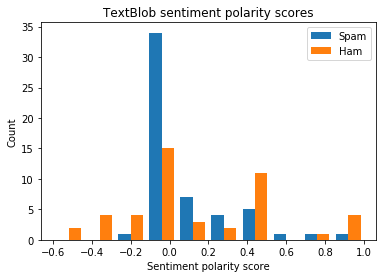

In [23]:
import matplotlib.pyplot as plt

spam_polarities = [
    textblob_sentiment(x).polarity for _, x in df_dev.iterrows() if x.label == SPAM
]

ham_polarities = [
    textblob_sentiment(x).polarity for _, x in df_dev.iterrows() if x.label == HAM
]

plt.hist([spam_polarities, ham_polarities])
plt.title("TextBlob sentiment polarity scores")
plt.xlabel("Sentiment polarity score")
plt.ylabel("Count")
plt.legend(["Spam", "Ham"])
plt.show()

Using our accuracy-over-coverage principle above, we'll target the high polarity bin on the far right in our LF since there are many more `HAM` comments.

In [24]:
@labeling_function(preprocessors=[textblob_sentiment])
def textblob_polarity(x):
    return HAM if x.polarity > 0.9 else ABSTAIN

Let's do the same for the subjectivity scores.
This will run faster than the last cell, since we memoized the `Preprocessor` outputs.

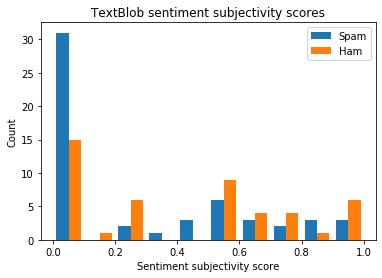

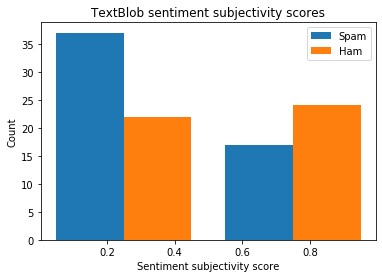

In [25]:
spam_subjectivities = [
    textblob_sentiment(x).subjectivity for _, x in df_dev.iterrows() if x.label == SPAM
]

ham_subjectivities = [
    textblob_sentiment(x).subjectivity for _, x in df_dev.iterrows() if x.label == HAM
]

plt.hist([spam_subjectivities, ham_subjectivities])
plt.title("TextBlob sentiment subjectivity scores")
plt.xlabel("Sentiment subjectivity score")
plt.ylabel("Count")
plt.legend(["Spam", "Ham"])
plt.show()

plt.hist([spam_subjectivities, ham_subjectivities], bins=[0, 0.5, 1])
plt.title("TextBlob sentiment subjectivity scores")
plt.xlabel("Sentiment subjectivity score")
plt.ylabel("Count")
plt.legend(["Spam", "Ham"])
plt.show()

It looks like subjectivity scores above 0.5 will work pretty well for identifying `HAM` comments, though not perfectly.
We'll rely on our label model to learn that this is a lower accuracy rule.

In [26]:
@labeling_function(preprocessors=[textblob_sentiment])
def textblob_subjectivity(x):
    return HAM if x.subjectivity >= 0.5 else ABSTAIN

Let's apply our LFs so we can analyze their performance.

In [27]:
lfs = [textblob_polarity, textblob_subjectivity]

applier = PandasLFApplier(lfs)
L_train = applier.apply(df_train)
L_dev = applier.apply(df_dev)

  0%|          | 0/1586 [00:00<?, ?it/s]

  7%|‚ñã         | 111/1586 [00:00<00:01, 1104.51it/s]

 14%|‚ñà‚ñç        | 221/1586 [00:00<00:01, 1101.50it/s]

 21%|‚ñà‚ñà        | 331/1586 [00:00<00:01, 1100.05it/s]

 28%|‚ñà‚ñà‚ñä       | 440/1586 [00:00<00:01, 1094.13it/s]

 35%|‚ñà‚ñà‚ñà‚ñç      | 548/1586 [00:00<00:00, 1088.01it/s]

 40%|‚ñà‚ñà‚ñà‚ñà      | 639/1586 [00:00<00:01, 886.89it/s] 

 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 751/1586 [00:00<00:00, 944.54it/s]

 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 866/1586 [00:00<00:00, 996.89it/s]

 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 980/1586 [00:00<00:00, 1035.44it/s]

 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 1092/1586 [00:01<00:00, 1058.35it/s]

 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 1202/1586 [00:01<00:00, 1070.36it/s]

 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 1310/1586 [00:01<00:00, 1072.81it/s]

 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 1425/1586 [00:01<00:00, 1094.67it/s]

 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 1536/1586 [00:01<00:00, 1096.53it/s]

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1586/1586 [00:01<00:00, 1059.12it/s]


  0%|          | 0/100 [00:00<?, ?it/s]

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [00:00<00:00, 14803.08it/s]

In [28]:
LFAnalysis(L_train, lfs).lf_summary()

j Polarity  Coverage  Overlaps  Conflicts
textblob_polarity      0  [0]      0.035309  0.013871  0.0      
textblob_subjectivity  1  [0]      0.357503  0.013871  0.0

In [29]:
LFAnalysis(L_dev, lfs).lf_summary(Y_dev)

j Polarity  Coverage  Overlaps  Conflicts  Correct  \
textblob_polarity      0  [0]      0.05      0.02      0.0        4         
textblob_subjectivity  1  [0]      0.41      0.02      0.0        24        

                       Incorrect  Emp. Acc.  
textblob_polarity      1          0.800000   
textblob_subjectivity  17         0.585366

Again, these LFs aren't perfect, so we'll rely on our label model to denoise and resolve their outputs.

## More Labeling Functions

If a single LF had high enough coverage to label our entire test dataset accurately, then we wouldn't need a classifier at all.
We could just use that single simple heuristic to complete the task.
But most problems are not that simple.
Instead, we usually need to **combine multiple LFs** to label our dataset, both to increase the size of the generated training set (since we can't generate training labels for data points that all LFs abstained on) and to improve the overall accuracy of the training labels we generate by factoring in multiple different signals.

In the following sections, we'll show just a few of the many types of LFs that you could write to generate a training dataset for this problem.

### i. Keyword LFs

For text applications, some of the simplest LFs to write are often just keyword lookups.
These will often follow the same execution pattern, so we can create a template and use the `resources` parameter to pass in LF-specific keywords.

In [30]:
from snorkel.labeling.lf import LabelingFunction


def keyword_lookup(x, keywords, label):
    if any(word in x.text.lower() for word in keywords):
        return label
    return ABSTAIN


def make_keyword_lf(keywords, label=SPAM):
    return LabelingFunction(
        name=f"keyword_{keywords[0]}",
        f=keyword_lookup,
        resources=dict(keywords=keywords, label=label),
    )


"""Spam comments talk about 'my channel', 'my video', etc."""
keyword_my = make_keyword_lf(["my"])

"""Spam comments ask users to subscribe to their channels."""
keyword_subscribe = make_keyword_lf(["subscribe"])

"""Spam comments post links to other channels."""
keyword_link = make_keyword_lf(["http"])

"""Spam comments make requests rather than commenting."""
keyword_please = make_keyword_lf(["please", "plz"])

"""Ham comments actually talk about the video's content."""
keyword_song = make_keyword_lf(["song"], label=HAM)

### ii. Pattern-matching LFs (regular expressions)

If we want a little more control over a keyword search, we can look for regular expressions instead.
The LF we developed above (`regex_check_out`) is an example of this.

### iii.  Heuristic LFs

There may other heuristics or "rules of thumb" that you come up with as you look at the data.
So long as you can express it in a function, it's a viable LF!

In [31]:
@labeling_function()
def short_comment(x):
    """Ham comments are often short, such as 'cool video!'"""
    return HAM if len(x.text.split()) < 5 else ABSTAIN

### iv. LFs with Complex Preprocessors

Some LFs rely on fields that aren't present in the raw data, but can be derived from it.
We can enrich our data (providing more fields for the LFs to refer to) using `Preprocessor`s.

For example, we can use the fantastic NLP tool [spaCy](https://spacy.io/) to add lemmas, part-of-speech (pos) tags, etc. to each token.
Snorkel provides a prebuilt preprocessor for spaCy called `SpacyPreprocessor` which adds a new field to the
data point containing a [spaCy `Doc` object](https://spacy.io/api/doc).
For more info, see the [`SpacyPreprocessor` documentation](https://snorkel.readthedocs.io/en/master/source/snorkel.labeling.preprocess.html#snorkel.labeling.preprocess.nlp.SpacyPreprocessor).


If you prefer to use a different NLP tool, you can also wrap that as a `Preprocessor` and use it in the same way.
For more info, see the [`preprocessor` documentation](https://snorkel.readthedocs.io/en/master/source/snorkel.labeling.preprocess.html#snorkel.labeling.preprocess.core.preprocessor).

In [32]:
# Download the spaCy english model
# If you see an error in the next cell, restart the kernel
! python -m spacy download en_core_web_sm

     |                                | 10kB 31.2MB/s eta 0:00:01

     |‚ñè                               | 51kB 640kB/s eta 0:00:18

     |‚ñé                               | 112kB 637kB/s eta 0:00:18

     |‚ñä                               | 256kB 637kB/s eta 0:00:17

     |‚ñà‚ñå                              | 532kB 637kB/s eta 0:00:17

     |‚ñà‚ñà‚ñà‚ñè                            | 1.1MB 637kB/s eta 0:00:16

     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                         | 2.3MB 637kB/s eta 0:00:14

     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                         | 2.3MB 637kB/s eta 0:00:14

     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                     | 3.8MB 637kB/s eta 0:00:12

     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                | 5.3MB 637kB/s eta 0:00:09

     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                | 5.4MB 637kB/s eta 0:00:09

     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà            | 6.9MB 637kB/s eta 0:00:07

     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå       | 8.5MB 637kB/s eta 0:00:05

     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä       | 8.5MB 637kB/s eta 0:00:04

     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 10.0MB 637kB/s eta 0:00:02

     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 10.6MB 637kB/s eta 0:00:01

     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 11.1MB 637kB/s 


 \

 |

 /

 -

 done
  Stored in directory: /tmp/pip-ephem-wheel-cache-2w6eyo6x/wheels/39/ea/3b/507f7df78be8631a7a3d7090962194cf55bc1158572c0be77f


Successfully built en-core-web-sm


You should consider upgrading via the 'pip install --upgrade pip' command.
‚úî Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [33]:
from snorkel.labeling.preprocess.nlp import SpacyPreprocessor

# The SpacyPreprocessor parses the text in text_field and
# stores the new enriched representation in doc_field
spacy = SpacyPreprocessor(text_field="text", doc_field="doc", memoize=True)


@labeling_function(preprocessors=[spacy])
def has_person(x):
    """Ham comments mention specific people and are short."""
    if len(x.doc) < 20 and any([ent.label_ == "PERSON" for ent in x.doc.ents]):
        return HAM
    else:
        return ABSTAIN

Because spaCy is such a common preprocessor for NLP (Natural Language Processing) applications, we also provide an alias for a `labeling_function` that uses spaCy. This resulting LF is identical to the one defined manually above.

In [34]:
from snorkel.labeling.lf.nlp import nlp_labeling_function


@nlp_labeling_function()
def has_person_nlp(x):
    """Ham comments mention specific people and are short."""
    if len(x.doc) < 20 and any([ent.label_ == "PERSON" for ent in x.doc.ents]):
        return HAM
    else:
        return ABSTAIN

**Adding new domain-specific preprocessors and LF types is a great way to contribute to Snorkel!
If you have an idea, feel free to reach out to the maintainers or submit a PR!**

### v. Third-party Model LFs

We can also utilize other models, including ones trained for other tasks that are related to, but not the same as, the one we care about.
The TextBlob-based LFs we created above are great examples of this!

### Applying our LFs

This tutorial demonstrates just a handful of the types of LFs that one might write for this task.
Many of these are no doubt suboptimal.
The strength of this approach, however, is that the LF abstraction provides a flexible interface for conveying a huge variety of supervision signals, and the `LabelModel` is able to denoise these signals, reducing the need for painstaking manual fine-tuning.

In [35]:
lfs = [
    keyword_my,
    keyword_subscribe,
    keyword_link,
    keyword_please,
    keyword_song,
    regex_check_out,
    short_comment,
    has_person_nlp,
    textblob_polarity,
    textblob_subjectivity,
]

With our full set of LFs, we can now apply these once again with `LFApplier` to get our the label matrices for the `train` and `dev` splits.
We'll use the `train` split's label matrix to generate training labels with the Label Model.
The `dev` split's label model is primarily helpful for looking at summary statistics.

The Pandas format provides an easy interface that many practioners are familiar with, but it is also less optimized for scale.
For larger datasets, more compute-intensive LFs, or larger LF sets, you may decide to use one of the other data formats
that Snorkel supports natively, such as Dask DataFrames or PySpark DataFrames, and their corresponding applier objects.
For more info, check out the [Snorkel API documentation](https://snorkel.readthedocs.io/en/master/source/snorkel.labeling.apply.html).

In [36]:
applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)
L_dev = applier.apply(df=df_dev)
L_valid = applier.apply(df=df_valid)

LFAnalysis(L=L_dev, lfs=lfs).lf_summary(Y=Y_dev)

  0%|          | 0/1586 [00:00<?, ?it/s]

  1%|          | 13/1586 [00:00<00:12, 128.49it/s]

  2%|‚ñè         | 25/1586 [00:00<00:12, 121.00it/s]

  2%|‚ñè         | 35/1586 [00:00<00:13, 113.19it/s]

  3%|‚ñé         | 47/1586 [00:00<00:13, 114.48it/s]

  4%|‚ñé         | 59/1586 [00:00<00:13, 115.77it/s]

  4%|‚ñç         | 71/1586 [00:00<00:13, 115.77it/s]

  5%|‚ñå         | 84/1586 [00:00<00:12, 118.23it/s]

  6%|‚ñå         | 96/1586 [00:00<00:12, 117.27it/s]

  7%|‚ñã         | 108/1586 [00:00<00:13, 112.13it/s]

  8%|‚ñä         | 120/1586 [00:01<00:12, 113.66it/s]

  8%|‚ñä         | 132/1586 [00:01<00:12, 112.94it/s]

  9%|‚ñâ         | 144/1586 [00:01<00:12, 113.19it/s]

 10%|‚ñâ         | 157/1586 [00:01<00:12, 117.75it/s]

 11%|‚ñà         | 170/1586 [00:01<00:11, 119.42it/s]

 11%|‚ñà‚ñè        | 182/1586 [00:01<00:13, 106.05it/s]

 12%|‚ñà‚ñè        | 194/1586 [00:01<00:12, 107.96it/s]

 13%|‚ñà‚ñé        | 205/1586 [00:01<00:12, 108.47it/s]

 14%|‚ñà‚ñé        | 218/1586 [00:01<00:12, 112.00it/s]

 15%|‚ñà‚ñç        | 230/1586 [00:02<00:12, 112.86it/s]

 15%|‚ñà‚ñå        | 242/1586 [00:02<00:11, 114.21it/s]

 16%|‚ñà‚ñå        | 254/1586 [00:02<00:11, 113.14it/s]

 17%|‚ñà‚ñã        | 266/1586 [00:02<00:11, 114.80it/s]

 18%|‚ñà‚ñä        | 278/1586 [00:02<00:11, 115.75it/s]

 18%|‚ñà‚ñä        | 290/1586 [00:02<00:11, 115.89it/s]

 19%|‚ñà‚ñâ        | 302/1586 [00:02<00:11, 111.97it/s]

 20%|‚ñà‚ñâ        | 314/1586 [00:02<00:11, 113.04it/s]

 21%|‚ñà‚ñà        | 327/1586 [00:02<00:10, 116.79it/s]

 21%|‚ñà‚ñà‚ñè       | 340/1586 [00:02<00:10, 118.83it/s]

 22%|‚ñà‚ñà‚ñè       | 354/1586 [00:03<00:10, 122.24it/s]

 23%|‚ñà‚ñà‚ñé       | 367/1586 [00:03<00:10, 115.00it/s]

 24%|‚ñà‚ñà‚ñç       | 380/1586 [00:03<00:10, 116.71it/s]

 25%|‚ñà‚ñà‚ñç       | 392/1586 [00:03<00:10, 117.13it/s]

 25%|‚ñà‚ñà‚ñå       | 404/1586 [00:03<00:10, 108.44it/s]

 26%|‚ñà‚ñà‚ñå       | 416/1586 [00:03<00:10, 108.82it/s]

 27%|‚ñà‚ñà‚ñã       | 429/1586 [00:03<00:10, 112.49it/s]

 28%|‚ñà‚ñà‚ñä       | 441/1586 [00:03<00:10, 108.72it/s]

 29%|‚ñà‚ñà‚ñä       | 453/1586 [00:03<00:10, 109.88it/s]

 29%|‚ñà‚ñà‚ñâ       | 465/1586 [00:04<00:10, 107.06it/s]

 30%|‚ñà‚ñà‚ñà       | 476/1586 [00:04<00:10, 107.10it/s]

 31%|‚ñà‚ñà‚ñà       | 487/1586 [00:04<00:10, 105.88it/s]

 31%|‚ñà‚ñà‚ñà‚ñè      | 498/1586 [00:04<00:10, 104.01it/s]

 32%|‚ñà‚ñà‚ñà‚ñè      | 510/1586 [00:04<00:09, 107.65it/s]

 33%|‚ñà‚ñà‚ñà‚ñé      | 521/1586 [00:04<00:10, 105.71it/s]

 34%|‚ñà‚ñà‚ñà‚ñé      | 532/1586 [00:04<00:09, 105.63it/s]

 34%|‚ñà‚ñà‚ñà‚ñç      | 543/1586 [00:04<00:09, 105.49it/s]

 35%|‚ñà‚ñà‚ñà‚ñå      | 556/1586 [00:04<00:09, 109.61it/s]

 36%|‚ñà‚ñà‚ñà‚ñå      | 568/1586 [00:05<00:09, 108.94it/s]

 37%|‚ñà‚ñà‚ñà‚ñã      | 580/1586 [00:05<00:09, 111.76it/s]

 37%|‚ñà‚ñà‚ñà‚ñã      | 592/1586 [00:05<00:09, 110.03it/s]

 38%|‚ñà‚ñà‚ñà‚ñä      | 604/1586 [00:05<00:08, 112.42it/s]

 39%|‚ñà‚ñà‚ñà‚ñâ      | 616/1586 [00:05<00:08, 111.10it/s]

 40%|‚ñà‚ñà‚ñà‚ñâ      | 629/1586 [00:05<00:08, 113.96it/s]

 40%|‚ñà‚ñà‚ñà‚ñà      | 641/1586 [00:05<00:08, 113.52it/s]

 41%|‚ñà‚ñà‚ñà‚ñà      | 653/1586 [00:05<00:08, 113.56it/s]

 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 665/1586 [00:05<00:08, 111.63it/s]

 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 677/1586 [00:06<00:08, 108.19it/s]

 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 688/1586 [00:06<00:08, 107.91it/s]

 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 699/1586 [00:06<00:08, 107.59it/s]

 45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 712/1586 [00:06<00:07, 113.41it/s]

 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 724/1586 [00:06<00:07, 115.28it/s]

 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 738/1586 [00:06<00:07, 118.11it/s]

 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 751/1586 [00:06<00:06, 121.18it/s]

 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 765/1586 [00:06<00:06, 124.51it/s]

 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 779/1586 [00:06<00:06, 127.50it/s]

 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 793/1586 [00:06<00:06, 126.21it/s]

 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 806/1586 [00:07<00:06, 123.47it/s]

 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 820/1586 [00:07<00:06, 127.19it/s]

 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 834/1586 [00:07<00:05, 130.44it/s]

 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 848/1586 [00:07<00:05, 130.75it/s]

 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 862/1586 [00:07<00:05, 132.34it/s]

 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 876/1586 [00:07<00:05, 130.52it/s]

 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 890/1586 [00:07<00:05, 128.16it/s]

 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 903/1586 [00:07<00:05, 126.98it/s]

 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 916/1586 [00:07<00:05, 126.85it/s]

 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 930/1586 [00:08<00:05, 128.01it/s]

 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 943/1586 [00:08<00:05, 117.09it/s]

 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 957/1586 [00:08<00:05, 120.90it/s]

 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 970/1586 [00:08<00:05, 121.88it/s]

 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 983/1586 [00:08<00:05, 119.75it/s]

 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 996/1586 [00:08<00:04, 121.54it/s]

 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 1010/1586 [00:08<00:04, 125.51it/s]

 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 1023/1586 [00:08<00:04, 123.84it/s]

 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 1036/1586 [00:08<00:04, 124.60it/s]

 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 1049/1586 [00:09<00:04, 122.36it/s]

 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 1062/1586 [00:09<00:04, 124.29it/s]

 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 1075/1586 [00:09<00:04, 122.73it/s]

 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 1088/1586 [00:09<00:04, 121.21it/s]

 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 1101/1586 [00:09<00:03, 121.34it/s]

 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 1114/1586 [00:09<00:04, 114.94it/s]

 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 1126/1586 [00:09<00:03, 115.94it/s]

 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 1140/1586 [00:09<00:03, 120.98it/s]

 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 1153/1586 [00:09<00:03, 118.87it/s]

 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 1165/1586 [00:10<00:03, 113.65it/s]

 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 1178/1586 [00:10<00:03, 113.50it/s]

 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 1190/1586 [00:10<00:03, 115.23it/s]

 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 1202/1586 [00:10<00:03, 113.60it/s]

 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 1214/1586 [00:10<00:03, 112.79it/s]

 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 1227/1586 [00:10<00:03, 115.41it/s]

 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 1239/1586 [00:10<00:03, 110.43it/s]

 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 1251/1586 [00:10<00:02, 112.19it/s]

 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 1263/1586 [00:10<00:02, 108.79it/s]

 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 1276/1586 [00:11<00:02, 111.48it/s]

 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 1288/1586 [00:11<00:02, 107.81it/s]

 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 1299/1586 [00:11<00:02, 106.85it/s]

 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 1310/1586 [00:11<00:02, 103.97it/s]

 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 1323/1586 [00:11<00:02, 109.94it/s]

 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 1335/1586 [00:11<00:02, 112.66it/s]

 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 1347/1586 [00:11<00:02, 113.87it/s]

 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 1359/1586 [00:11<00:01, 114.90it/s]

 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 1372/1586 [00:11<00:01, 117.04it/s]

 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 1384/1586 [00:11<00:01, 116.34it/s]

 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 1396/1586 [00:12<00:01, 116.09it/s]

 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 1409/1586 [00:12<00:01, 118.45it/s]

 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 1421/1586 [00:12<00:01, 118.64it/s]

 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 1433/1586 [00:12<00:01, 116.52it/s]

 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 1445/1586 [00:12<00:01, 108.81it/s]

 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 1457/1586 [00:12<00:01, 111.07it/s]

 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 1469/1586 [00:12<00:01, 109.12it/s]

 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 1481/1586 [00:12<00:00, 107.76it/s]

 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 1492/1586 [00:12<00:00, 101.95it/s]

 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 1504/1586 [00:13<00:00, 104.61it/s]

 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 1515/1586 [00:13<00:00, 102.26it/s]

 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 1527/1586 [00:13<00:00, 105.80it/s]

 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 1540/1586 [00:13<00:00, 112.01it/s]

 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 1552/1586 [00:13<00:00, 112.55it/s]

 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 1564/1586 [00:13<00:00, 106.87it/s]

 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 1578/1586 [00:13<00:00, 113.35it/s]

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1586/1586 [00:13<00:00, 114.79it/s]


  0%|          | 0/100 [00:00<?, ?it/s]

 13%|‚ñà‚ñé        | 13/100 [00:00<00:00, 121.98it/s]

 23%|‚ñà‚ñà‚ñé       | 23/100 [00:00<00:00, 113.55it/s]

 35%|‚ñà‚ñà‚ñà‚ñå      | 35/100 [00:00<00:00, 115.27it/s]

 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 47/100 [00:00<00:00, 116.25it/s]

 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 59/100 [00:00<00:00, 117.19it/s]

 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 70/100 [00:00<00:00, 114.05it/s]

 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 81/100 [00:00<00:00, 110.58it/s]

 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 93/100 [00:00<00:00, 112.36it/s]

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [00:00<00:00, 111.95it/s]


  0%|          | 0/120 [00:00<?, ?it/s]

  8%|‚ñä         | 9/120 [00:00<00:01, 82.81it/s]

 15%|‚ñà‚ñå        | 18/120 [00:00<00:01, 84.49it/s]

 23%|‚ñà‚ñà‚ñé       | 28/120 [00:00<00:01, 87.90it/s]

 31%|‚ñà‚ñà‚ñà       | 37/120 [00:00<00:00, 85.91it/s]

 39%|‚ñà‚ñà‚ñà‚ñâ      | 47/120 [00:00<00:00, 89.40it/s]

 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 58/120 [00:00<00:00, 93.12it/s]

 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 69/120 [00:00<00:00, 95.61it/s]

 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 80/120 [00:00<00:00, 98.66it/s]

 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 91/120 [00:00<00:00, 101.36it/s]

 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 103/120 [00:01<00:00, 104.60it/s]

 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 114/120 [00:01<00:00, 105.75it/s]

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 120/120 [00:01<00:00, 98.92it/s] 

j Polarity  Coverage  Overlaps  Conflicts  Correct  \
keyword_my             0  [1]      0.22      0.22      0.14       19        
keyword_subscribe      1  [1]      0.14      0.12      0.06       14        
keyword_http           2  [1]      0.10      0.08      0.07       10        
keyword_please         3  [1]      0.10      0.10      0.06       10        
keyword_song           4  [0]      0.16      0.12      0.06       11        
regex_check_out        5  [1]      0.29      0.22      0.17       29        
short_comment          6  [0]      0.28      0.20      0.07       19        
has_person_nlp         7  [0]      0.15      0.13      0.04       10        
textblob_polarity      8  [0]      0.05      0.05      0.01       4         
textblob_subjectivity  9  [0]      0.41      0.34      0.20       24        

                       Incorrect  Emp. Acc.  
keyword_my             3          0.863636   
keyword_subscribe      0          1.000000   
keyword_http           0          1.000000   
keyword_please         0          1.000000   
keyword_song           5          0.687500   
regex_check_out        0          1.000000   
short_comment          9          0.678571   
has_person_nlp         5          0.666667   
textblob_polarity      1          0.800000   
textblob_subjectivity  17         0.585366

We see that our labeling functions vary in coverage, accuracy, and how much they overlap/conflict with one another.
We can view a histogram of how many LF labels the data points in our dev set have to get an idea of our total coverage.

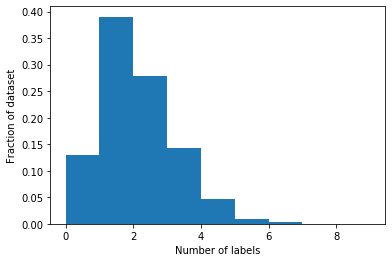

In [37]:
def plot_label_frequency(L):
    plt.hist((L != ABSTAIN).sum(axis=1), density=True, bins=range(L.shape[1]))
    plt.xlabel("Number of labels")
    plt.ylabel("Fraction of dataset")
    plt.show()


plot_label_frequency(L_train)

We see that over half of our `train` dataset data points have 2 or fewer labels from LFs.
Fortunately, the signal we do have can be used to train a classifier over the comment text directly, allowing it to generalize beyond what we've specified via our LFs.

## 3. Combining Labeling Function Outputs with the Label Model

Our goal is now to convert the labels from our LFs into a single _noise-aware_ probabilistic (or confidence-weighted) label per data point.
A simple baseline for doing this is to take the majority vote on a per-data point basis: if more LFs voted SPAM than HAM, label it SPAM (and vice versa).

In [38]:
from snorkel.labeling.model import MajorityLabelVoter

majority_model = MajorityLabelVoter()
Y_pred_train = majority_model.predict(L=L_train)
Y_pred_train

array([1, 1, 0, ..., 1, 1, 1])

However, as we can clearly see by looking the summary statistics of our LFs in the previous section, they are not all equally accurate, and should not be treated identically. In addition to having varied accuracies and coverages, LFs may be correlated, resulting in certain signals being overrepresented in a majority-vote-based model. To handle these issues appropriately, we will instead use a more sophisticated Snorkel `LabelModel` to combine the outputs of the LFs.

This model will ultimately produce a single set of noise-aware training labels, which are probabilistic or confidence-weighted labels. We will then use these labels to train a classifier for our task. For more technical details of this overall approach, see our [NeurIPS 2016](https://arxiv.org/abs/1605.07723) and [AAAI 2019](https://arxiv.org/abs/1810.02840) papers. For more info on the API, see the [`LabelModel` documentation](https://snorkel.readthedocs.io/en/master/source/snorkel.labeling.model.html#snorkel.labeling.model.label_model.LabelModel).

Note that no gold labels are used during the training process.
The `LabelModel` is able to learn weights for the labeling functions using only the label matrix as input.
We also specify the `cardinality`, or number of classes.

In [39]:
from snorkel.labeling.model import LabelModel

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train, n_epochs=1000, lr=0.001, log_freq=100, seed=123)

Computing O...
Estimating \mu...
[0 epochs]: TRAIN:[loss=0.164]
[100 epochs]: TRAIN:[loss=0.025]
[200 epochs]: TRAIN:[loss=0.018]
[300 epochs]: TRAIN:[loss=0.017]


[400 epochs]: TRAIN:[loss=0.015]
[500 epochs]: TRAIN:[loss=0.014]
[600 epochs]: TRAIN:[loss=0.013]
[700 epochs]: TRAIN:[loss=0.012]


[800 epochs]: TRAIN:[loss=0.012]
[900 epochs]: TRAIN:[loss=0.011]
Finished Training


In [40]:
majority_acc = majority_model.score(L=L_valid, Y=Y_valid)["accuracy"]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_valid, Y=Y_valid)["accuracy"]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   84.2%
Label Model Accuracy:     86.7%


So our `LabelModel` improves over the majority vote baseline!
However, it is typically **not suitable as an inference-time model** to make predictions for unseen examples, due to (among other things) some data points having all abstain labels.
In the next section, we will use the output of the label model as  training labels to train a
discriminative classifier to see if we can improve performance further.
This classifier will only need the text of the comment to make predictions, making it much more suitable
for inference over unseen comments.
For more information on the properties of the label model and when to use it, see the [Snorkel guides]().

We can also run error analysis after the label model has been trained.
For example, let's take a look at false positives from the `dev` set, which might inspire some more LFs that vote `SPAM`.

In [41]:
Y_dev_prob = majority_model.predict_proba(L=L_dev)
Y_dev_pred = Y_dev_prob >= 0.5
buckets = error_buckets(golds=Y_dev, preds=Y_dev_pred[:, 1])

df_dev_fp = df_dev[["text", "label"]].iloc[buckets[(HAM, SPAM)]]
df_dev_fp["probability"] = Y_dev_prob[buckets[(HAM, SPAM)], 1]

df_dev_fp.sample(5, random_state=3)

text  \
195  Check Out The New Hot Video By Dante B Called Riled Up                              
334  Check out Em&#39;s dope new song monster here: /watch?v=w6gkM-XNY2M  MMLP2 FTW :)   
431  CHECK OUT Eminem - Rap God LYRIC VIDEO                                              
313  Aslamu Lykum... From PakistanÔªø                                                      
189  /watch?v=aImbWbfQbzg watch and subscrible                                           

     label  probability  
195  1      0.0          
334  1      0.0          
431  1      0.0          
313  1      0.0          
189  1      0.0

Let's briefly confirm that the labels the `LabelModel` produces are probabilistic in nature.
The following histogram shows the confidences we have that each data point has the label SPAM.
The points we are least certain about will have labels close to 0.5.

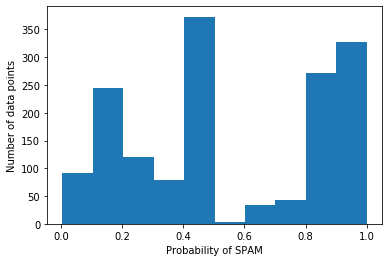

In [42]:
def plot_probabilities_histogram(Y):
    plt.hist(Y, bins=10)
    plt.xlabel("Probability of SPAM")
    plt.ylabel("Number of data points")
    plt.show()


Y_probs_train = label_model.predict_proba(L=L_train)
plot_probabilities_histogram(Y_probs_train[:, SPAM])

### Filtering out unlabeled data points

As we saw earlier, some of the data points in our `train` set received no labels from any of our LFs.
These examples convey no supervision signal and tend to hurt performance, so we filter them out before training.

In [43]:
from snorkel.labeling.utils import filter_unlabeled_dataframe

df_train_filtered, Y_probs_train_filtered = filter_unlabeled_dataframe(
    X=df_train, y=Y_probs_train, L=L_train
)

## 4. Training a Classifier

In this final section of the tutorial, we'll use the noisy training labels we generated in the last section to train a classifier for our task.

Note that because the output of the Snorkel `LabelModel` is just a set of labels, Snorkel easily integrates with most popular libraries for performing supervised learning: TensorFlow, Keras, PyTorch, Scikit-Learn, Ludwig, XGBoost, etc.

In this tutorial we demonstrate using classifiers from Keras and Scikit-Learn.

### Featurization

For simplicity and speed, we use a simple "bag of n-grams" feature representation: each data point is represented by a one-hot vector marking which words or 2-word combinations are present in the comment text.

In [44]:
from sklearn.feature_extraction.text import CountVectorizer

words_train = [row.text for i, row in df_train_filtered.iterrows()]
words_dev = [row.text for i, row in df_dev.iterrows()]
words_valid = [row.text for i, row in df_valid.iterrows()]
words_test = [row.text for i, row in df_test.iterrows()]

vectorizer = CountVectorizer(ngram_range=(1, 2))
X_train = vectorizer.fit_transform(words_train)
X_dev = vectorizer.transform(words_dev)
X_valid = vectorizer.transform(words_valid)
X_test = vectorizer.transform(words_test)

### Keras Classifier with Probabilistic Labels

We'll use Keras, a popular high-level API for building models in TensorFlow, to build a simple logistic regression classifier.
We compile it with a `categorical_crossentropy` loss so that it can handle probabilistic labels instead of integer labels.
Using a _noise-aware loss_ &mdash; one that uses probabilistic labels &mdash; for our discriminative model lets
us take full advantage of the label model's learning procedure (see our [NeurIPS 2016 paper](https://arxiv.org/abs/1605.07723)).
We use the common settings of an `Adam` optimizer and early stopping (evaluating the model on the validation set after each epoch and reloading the weights from when it achieved the best score).
For more information on Keras, see the [Keras documentation](https://keras.io/).

This next cell makes our Keras results reproducible. You can ignore it.

In [45]:
import numpy as np
import random
import tensorflow as tf

seed = 1
np.random.seed(seed)
random.seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, inter_op_parallelism_threads=1
)

from tensorflow.keras import backend as K

tf.set_random_seed(seed)
sess = tf.compat.v1.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [46]:
from snorkel.analysis.utils import probs_to_preds, preds_to_probs
from snorkel.analysis.metrics import metric_score

# Our model is a simple linear layer mapping from feature
# vectors to the number of labels in our problem (2).
keras_model = tf.keras.Sequential()
keras_model.add(
    tf.keras.layers.Dense(
        units=2,
        input_dim=X_train.shape[1],
        activation=tf.nn.softmax,
        kernel_regularizer=tf.keras.regularizers.l2(0.001),
    )
)
optimizer = tf.keras.optimizers.Adam(lr=0.01)
keras_model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_acc", patience=10, verbose=1, restore_best_weights=True
)

keras_model.fit(
    x=X_train,
    y=Y_probs_train_filtered,
    validation_data=(X_valid, preds_to_probs(Y_valid, 2)),
    callbacks=[early_stopping],
    epochs=20,
    verbose=0,
)

Y_probs_test = keras_model.predict(x=X_test)
Y_preds_test = probs_to_preds(probs=Y_probs_test)
test_acc = metric_score(golds=Y_test, preds=Y_preds_test, metric="accuracy")
print(f"Test Accuracy: {test_acc * 100:.1f}%")

W0803 01:36:54.880029 139989386307392 deprecation.py:506] From /home/ubuntu/snorkel-tutorials/.tox/spam/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
Test Accuracy: 94.4%


**We observe an additional boost in accuracy over the `LabelModel` by multiple points!
By using the label model to transfer the domain knowledge encoded in our LFs to the discriminative model,
we were able to generalize beyond the noisy labeling heuristics**.

We can compare this to the score we could have gotten if we had used our small labeled `dev` set directly as training data instead of using it to guide the creation of LFs.

In [47]:
keras_dev_model = tf.keras.Sequential()
keras_dev_model.add(
    tf.keras.layers.Dense(
        units=1,
        input_dim=X_train.shape[1],
        activation=tf.nn.sigmoid,
        kernel_regularizer=tf.keras.regularizers.l2(0.001),
    )
)
optimizer = tf.keras.optimizers.Adam(lr=0.001)
keras_dev_model.compile(
    optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
)

keras_dev_model.fit(
    x=X_dev,
    y=Y_dev,
    validation_data=(X_valid, Y_valid),
    callbacks=[early_stopping],
    epochs=20,
    verbose=0,
)

Y_probs_test = keras_dev_model.predict(x=X_test)
Y_preds_test = np.round(Y_probs_test)
test_acc = metric_score(golds=Y_test, preds=Y_preds_test, metric="accuracy")
print(f"Test Accuracy: {test_acc * 100:.1f}%")

W0803 01:36:56.813885 139989386307392 deprecation.py:323] From /home/ubuntu/snorkel-tutorials/.tox/spam/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Test Accuracy: 88.4%


### Scikit-Learn with Rounded Labels

If we want to use a library or model that doesn't accept probabilistic labels, we can replace each label distribution with the label of the class that has the maximum probability.
This can easily be done using the helper method `probs_to_preds` (note, however, that this transformation is lossy, as we no longer have values for our confidence in each label).

In [48]:
Y_preds_train_filtered = probs_to_preds(probs=Y_probs_train_filtered)

For example, this allows us to use standard models from Scikit-Learn.

In [49]:
from sklearn.linear_model import LogisticRegression

sklearn_model = LogisticRegression(C=0.001, solver="liblinear")
sklearn_model.fit(X=X_train, y=Y_preds_train_filtered)

print(f"Test Accuracy: {sklearn_model.score(X=X_test, y=Y_test) * 100:.1f}%")

Test Accuracy: 93.2%


## Summary

In this tutorial, we accomplished the following:
* We introduced the concept of Labeling Functions (LFs) and demonstrated some of the forms they can take.
* We used the Snorkel `LabelModel` to automatically learn how to combine the outputs of our LFs into strong probabilistic labels.
* We showed that a classifier trained on a weakly supervised dataset can outperform an approach based on the LFs alone as it learns to generalize beyond the noisy heuristics we provide.

### Next Steps

If you enjoyed this tutorial and you've already checked out the Snorkel 101 Guide, check out the [`snorkel-tutorials` table of contents](https://github.com/snorkel-team/snorkel-tutorials#snorkel-tutorials) for other tutorials that you may find interesting, including demonstrations of how to use Snorkel

* As part of a [hybrid crowdsourcing pipeline](https://github.com/snorkel-team/snorkel-tutorials/tree/master/crowdsourcing)
* For [scene-graph detection over images](https://github.com/snorkel-team/snorkel-tutorials/tree/master/scene_graph)
* For [information extraction over text](https://github.com/snorkel-team/snorkel-tutorials/tree/master/spouse)
* For [data augmentation](https://github.com/snorkel-team/snorkel-tutorials/tree/master/spam)

and many more!
You can also visit the [Snorkel homepage](http://snorkel.org) or [Snorkel API documentation](https://snorkel.readthedocs.io) for more info!